In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

from ultralytics import YOLO
import cv2 as cv

In [35]:
# path_to_data = "/Datasets/EuRoC/MH01/mav0/cam0/data/"
# path_to_data = "/Datasets/TUM/rgbd_dataset_freiburg1_xyz/rgb/"
path_to_data = "/Datasets/TUM/rgbd_dataset_freiburg3_sitting_static/rgb/"

images_paths = []
images = []

for image_filename in sorted(os.listdir(path_to_data)):
	path = f'{path_to_data}{image_filename}'
	img = cv.imread(path, cv.IMREAD_GRAYSCALE)
	images_paths.append(path)
	images.append(img)

In [46]:
orb = cv.ORB_create()
model_trained = YOLO('/dl_ws/models/best.pt')

seg_res = model_trained(images_paths[0])
kp = orb.detect(images[0], None)
_,des = orb.compute(images[0], kp)

img_kp = cv.drawKeypoints(images[0], [kp[28]], None, color=(0,255,0), flags=0)
# plt.imshow(img_kp), plt.show()
# seg_res[0].show()

shape = images[0].shape
cls = seg_res[0].boxes.cls.tolist()
human_class_id = 0

human_class_idx = cls.index(human_class_id) if human_class_id in cls else -1
human_class_idxs  = [index for (index, item) in enumerate(cls) if item == human_class_id]
print(human_class_idxs)
# xy = seg_res[0].masks.xy[1].astype(np.int32)
# pt = kp[28].pt

# img = np.copy(seg_res[0].orig_img)
# b_mask = np.zeros(img.shape[:2], np.uint8)
# contour = xy.reshape(-1, 1, 2)
# cv.drawContours(b_mask, [contour], -1, (255, 255, 255), cv.FILLED)
# plt.imshow(b_mask, cmap='gray'), plt.show()

# col = int(pt[0])
# row = int(pt[1])
# b_mask[row][col]



image 1/1 /Datasets/TUM/rgbd_dataset_freiburg3_sitting_static/rgb/1341845688.561749.png: 480x640 2 persons, 1 chair, 2 tvs, 1 mouse, 2 keyboards, 242.2ms
Speed: 11.5ms preprocess, 242.2ms inference, 10.4ms postprocess per image at shape (1, 3, 480, 640)
[1, 3]


In [ ]:
# ORB features exctraction
def extract_orb(images_grayscale, paths):
	orb = cv.ORB_create()
	model = YOLO('/dl_ws/models/best.pt')

	kp_res = {}
	des_res = {}

	kp_dyna = {}
	des_dyna = {}

	for idx, img in enumerate(images_grayscale):
		kp = orb.detect(img, None)
		_, des = orb.compute(img, kp)
		seg_res = model(paths[idx])[0]

		boxes = seg_res.boxes
		masks = seg_res.masks
		cls = boxes.cls.tolist()
		human_class_id = 0
		human_class_idxs  = [index for (index, item) in enumerate(cls) if item == human_class_id]
		
		if (len(human_class_idxs)):
			kp_filtered = []
			des_filtered = []
			kp_rej = []
			des_rej = []

			for human_class_idx in human_class_idxs:
				xy = masks.xy[human_class_idx].astype(np.int32)

				for p_idx, p in enumerate(kp):
					img = np.copy(seg_res.orig_img)
					b_mask = np.zeros(img.shape[:2], np.uint8)
					contour = xy.reshape(-1, 1, 2)
					cv.drawContours(b_mask, [contour], -1, (255, 255, 255), cv.FILLED)

					col = int(p.pt[0])
					row = int(p.pt[1])

					if (b_mask[row][col] == 0):
						kp_filtered.append(p)
						des_filtered.append(des[p_idx])
					else:
						kp_rej.append(p)
						des_rej.append(des[p_idx])

				kp_res[idx] = tuple(kp_filtered)
				des_res[idx] = tuple(des_filtered)
				kp_dyna[idx] = tuple(kp_rej)
				des_dyna[idx] = tuple(des_rej)

		else:
			kp_res[idx] = kp
			des_res[idx] = des

	return kp_res, des_res, kp_dyna, des_dyna

batch_size = 30
kp_res, des_res, kp_dyna, des_dyna = extract_orb(images[:batch_size], images_paths[:batch_size])

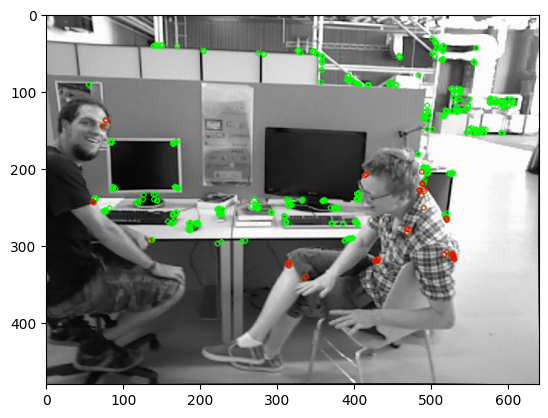

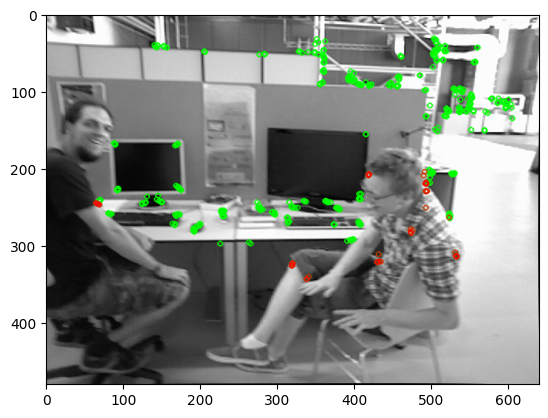

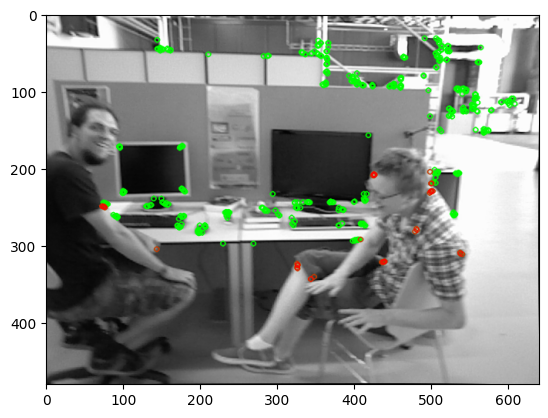

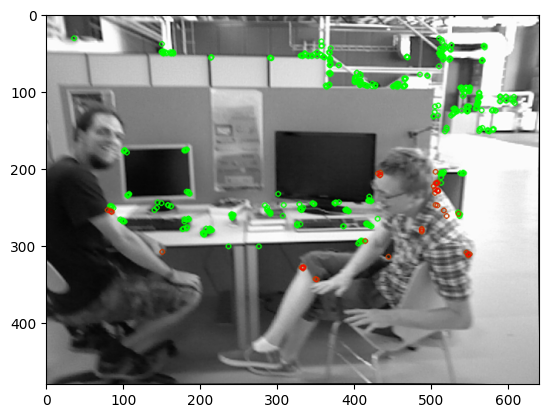

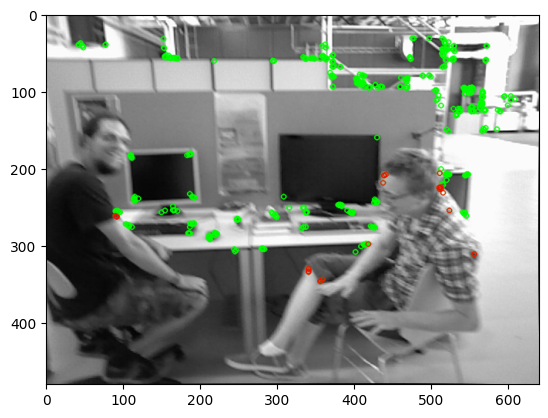

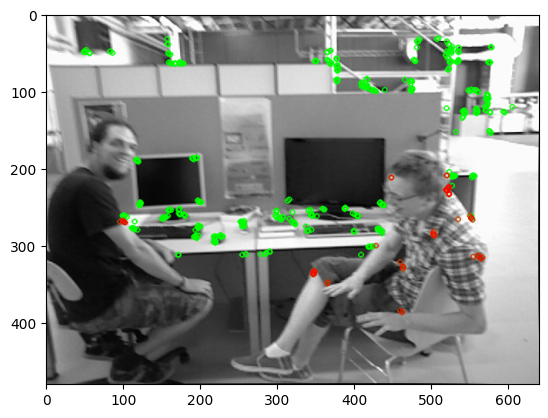

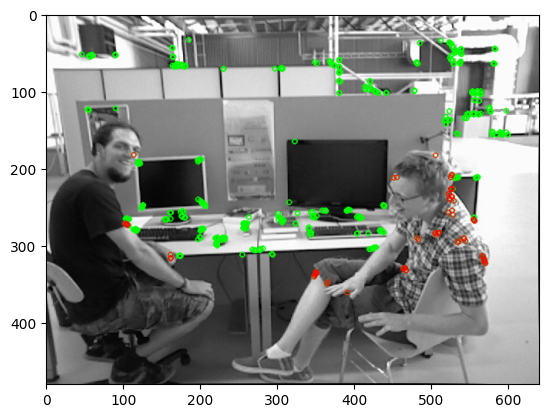

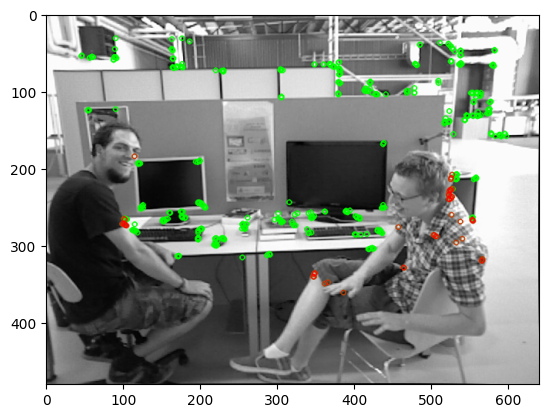

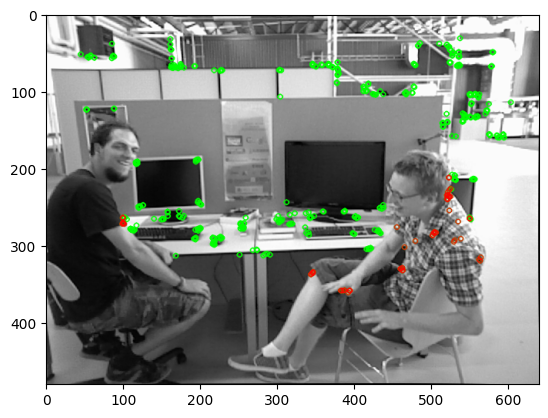

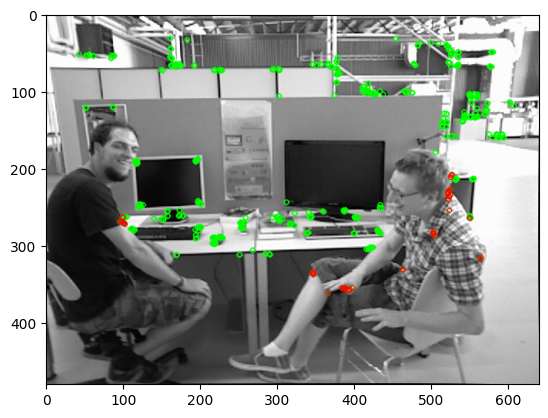

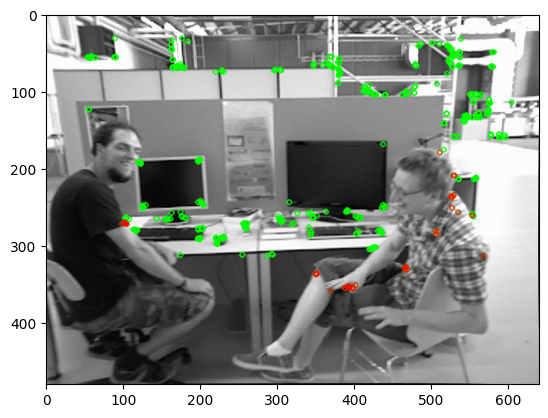

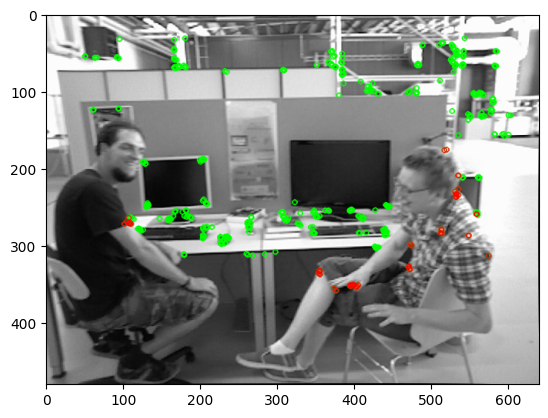

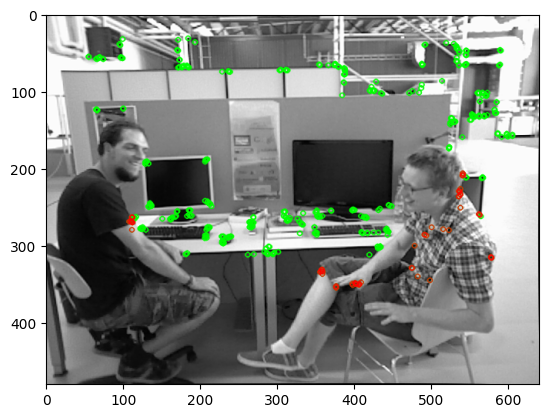

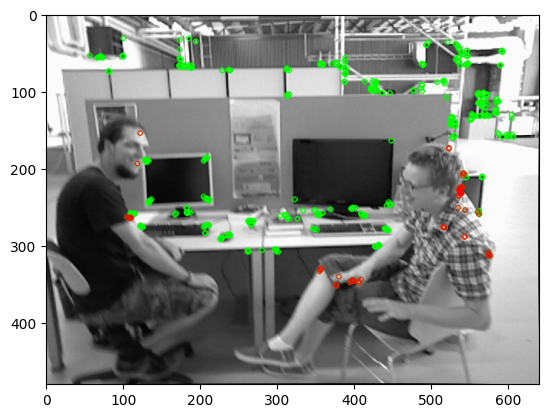

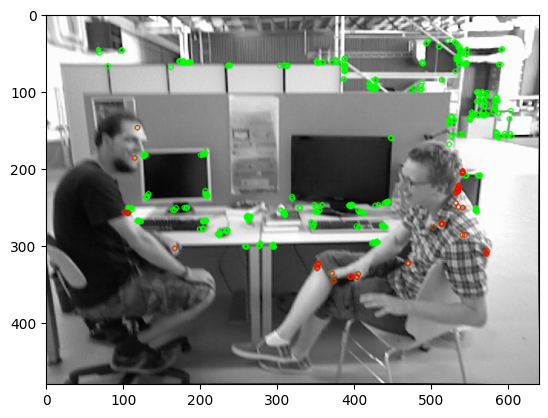

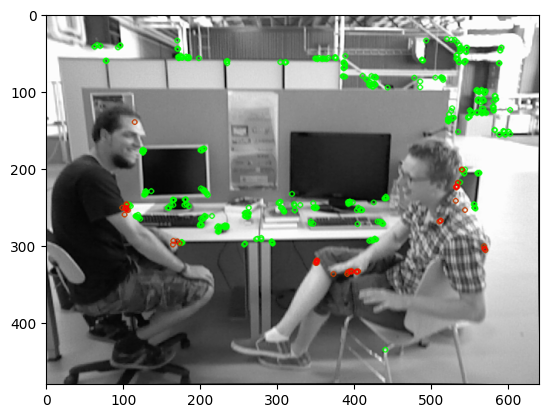

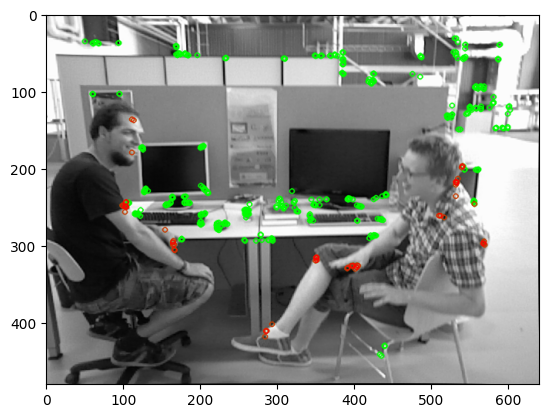

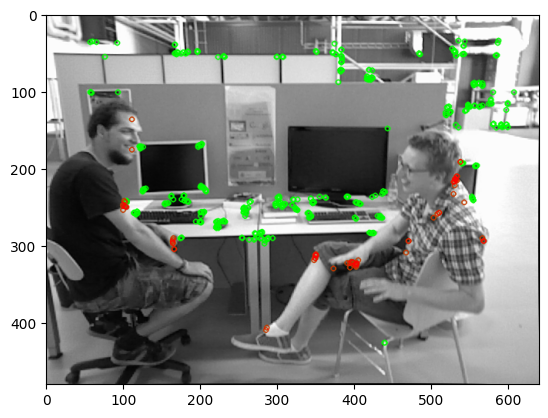

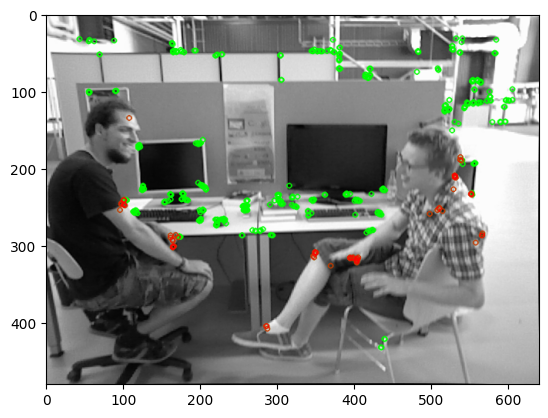

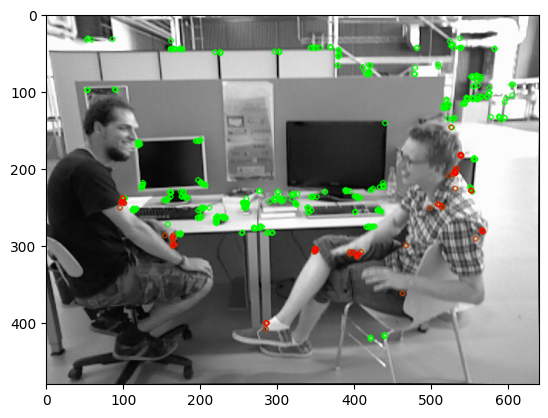

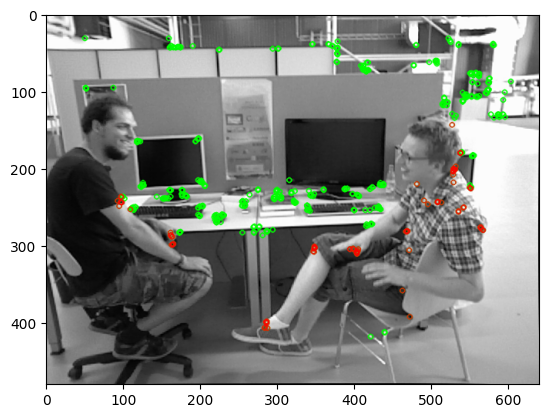

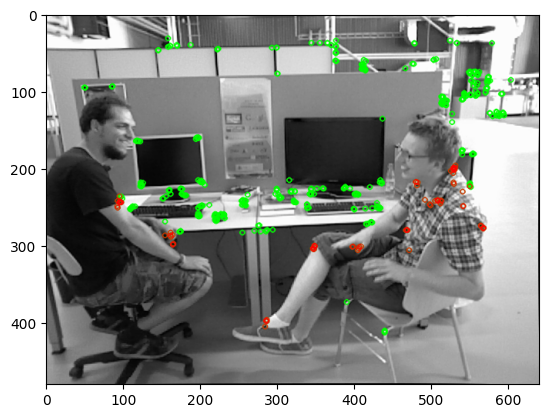

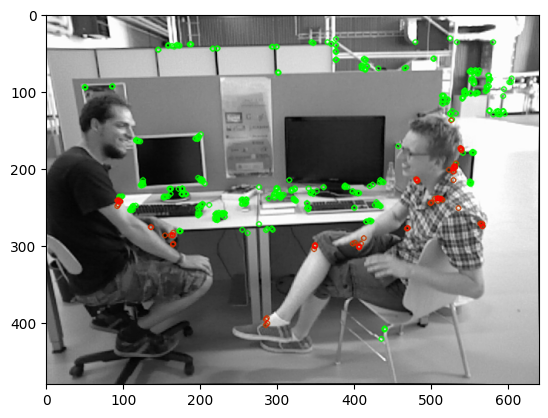

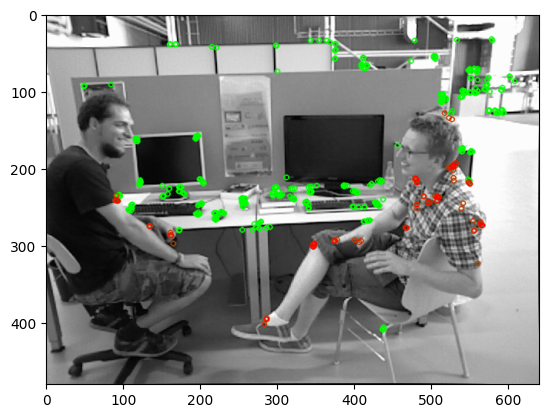

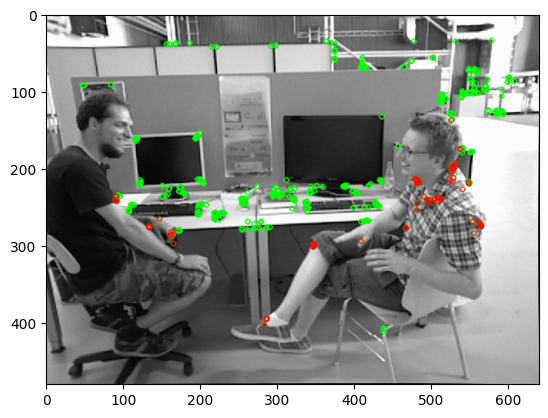

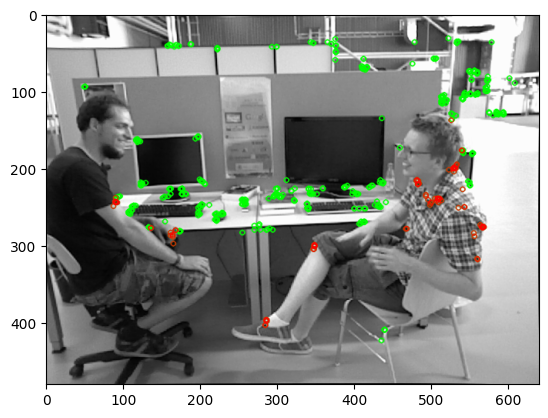

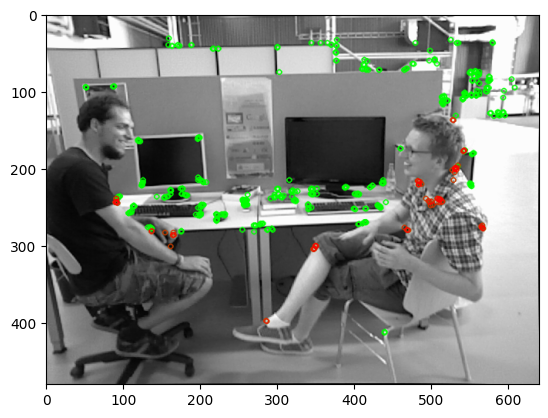

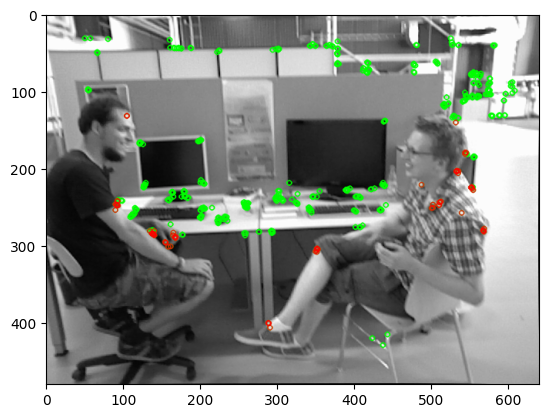

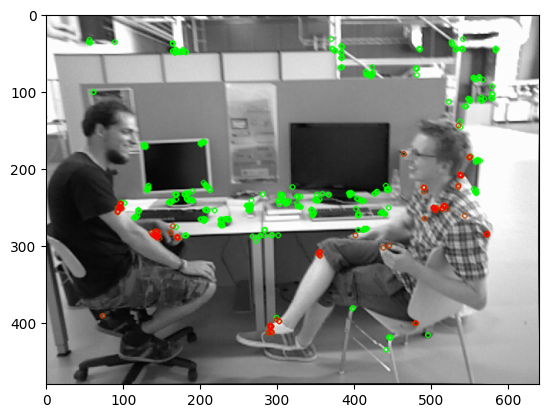

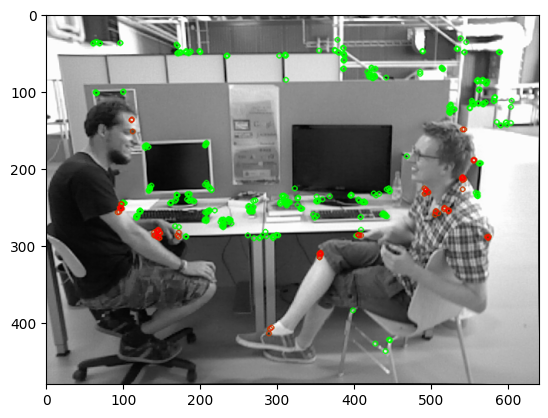

In [ ]:
for idx, img in enumerate(images[:batch_size]):
	img_kp = img
	if (idx in kp_res):
			img_kp = cv.drawKeypoints(img, kp_res[idx], None, color=(0,255,0), flags=0)

	if (idx in kp_dyna):
		img_kp = cv.drawKeypoints(img_kp, kp_dyna[idx], None, color=(255,0,0), flags=0)
	plt.imshow(img_kp), plt.show()
	